# Testing auto-pole-zero calculation.
# Sandbox notebook 

N.B. Switched origin in the pygama git cloned repo to that of Clint's, need to change it back if pygama-dev stuff is needed... 

S. Borden, C. Wiseman, Aug 2023.

First run the automatic calibration developed in `energy_raw.ipynb`. 

Then choose a couple waveforms from the 1460, 238, and 2615 peaks, and compute the pole-zero constants.

In [1]:
import os, h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/global/cfs/cdirs/legend/software/KrSTC/analysis/physrev.mpl')

from scipy.stats import mode

# NOTE: Pygama was refactored into oblivion after version 1.3, with
# essential functionality split out into multiple repositories.
# We are freezing our software at tags/v1.1.0.
# https://github.com/legend-exp/pygama/tree/v1.1.0

from pygama.flow import DataGroup
import pygama.lgdo as lgdo

import flattener # sam's code
from iminuit import Minuit

In [2]:
# Load test stand data from one cycle file

# fileDB query
que = 'cycle==3500'

# uncalibrated energy range
etype = 'energy'
tb_in = 'ORSIS3302DecoderForEnergy/dsp'
xlo, xhi, xpb = 0, 10e6, 10000 # onboard energy

# load the fileDB and make sure the entries exist
dg = DataGroup('/global/cfs/cdirs/legend/software/KrSTC/analysis/krstc.json', load=True)
dg.fileDB.query(que, inplace=True)
if len(dg.fileDB)==0:
    print('Error, no files found.  Check your query, and fileDB.h5.')

ecal_cols = ['run', 'cycle', 'skip', 'runtype', 'startTime', 'threshold', 'stopTime', 'runtime']
display(dg.fileDB[ecal_cols])

# load numpy arrays of uncalibrated energy
dsp_list = dg.lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
raw_data = lgdo.load_nda(dsp_list, [etype], tb_in)[etype]

# get runtime
runtime_min = dg.fileDB['runtime'].sum()

# print columns of table
with h5py.File(dsp_list.iloc[0], 'r') as hf:
    print('LH5 columns:', list(hf[f'{tb_in}'].keys()))

,run,cycle,skip,runtype,startTime,threshold,stopTime,runtime
1481,83.0,3500,False,kry,1.682790e+09,100.0,1.682791e+09,24.972746


LH5 columns: ['A_avg', 'A_gaus', 'bl', 'bl_intercept', 'bl_sig', 'bl_slope', 'channel', 'dcr', 'energy', 'ftp', 'stp_02', 'stp_05', 'stp_10', 'stp_20', 'stp_max', 'stp_min', 'swf_max', 'swf_min', 'timestamp', 'tmax', 'tp_0', 'tp_02', 'tp_05', 'tp_10', 'tp_20', 'tp_50', 'tp_90', 'tp_96', 'tp_max', 'tp_min', 'trapEftp', 'trapEmax', 'trapTmax', 'triE', 'wf_max', 'wf_min']


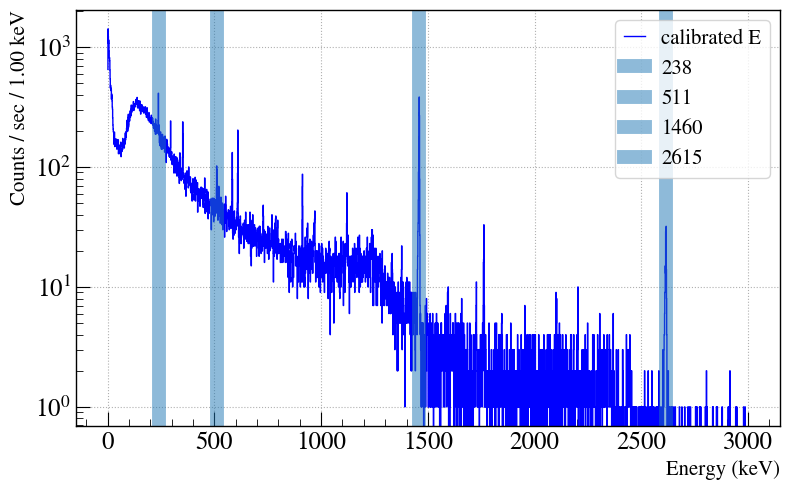

In [3]:
# Apply a rough calibration function (energy_raw.ipynb)
pk_locs = [238, 511, 1460, 2615]
pk_uncal = [567283, 1211543, 3462426, 6194491]
pars = np.polyfit(pk_uncal, pk_locs, 3)
pfunc = np.poly1d(pars)
data_cal = pfunc(raw_data)

# compute energy histogram
xlo, xhi, xpb = 0, 3000, 1
nbins = int((xhi-xlo)/xpb)
hh_cal, bb_cal = np.histogram(data_cal, bins=nbins, range=(xlo, xhi))

# -- diagnostic plot -- 
%matplotlib inline
fig = plt.figure()
fig.canvas.header_visible = False

plt.semilogy(bb_cal[1:], hh_cal, c='b', lw=1, ds='steps', label='calibrated E')

for pk in pk_locs:
    plt.axvline(pk, lw=10, alpha=0.5, label=f'{pk:.0f}')

plt.xlabel('Energy (keV)', ha='right', x=1, fontsize=15)
plt.ylabel(f'Counts / sec / {xpb:.2f} keV', ha='right', y=1, fontsize=15)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [60]:
# select waveforms from the 1460 peak

n_max = 100000 # num. of events to read into the first file
n_wf = 200      # num. of wfs to plot from the first n_max wfs in file.

# ix_select = np.where((data_cal > 1460) & (data_cal < 1460.1))
ix_select = np.where((data_cal > 230) & (data_cal < 240))

print(len(ix_select[0]))

f_raw = (dg.lh5_dir + '/' + dg.fileDB.raw_path + '/' + dg.fileDB.raw_file).values[0]

store = lgdo.LH5Store()
tb, n_found = store.read_object('ORSIS3302DecoderForEnergy/raw/waveform', f_raw, n_rows=n_max, idx=ix_select)

print(f'n_wf {n_wf}  n_found {n_found}')

# # pull numpy array of wf table
wfs = tb['values'].nda[:,:-2]

print(wfs.shape)

# compute baselines
bl_means = wfs[:,:500].mean(axis=1)

# 1. data cleaning step: remove events with outlier baselines
bl_thresh = 30 # allowable baseline ADC deviation
bl_mode = mode(bl_means.astype(int), keepdims=True)[0][0]
bl_ctr = np.subtract(bl_means, bl_mode)
idx_dc = np.where(np.abs(bl_ctr) < bl_thresh)
wfs = wfs[idx_dc[0],:]
bl_means = bl_means[idx_dc]
n_cleaned = wfs.shape[0]
# print(wfs.shape, bl_means.shape)

# 2. baseline subtract (trp when leading (not trailing) dim is the same)
wfs = (wfs.transpose() - bl_means).transpose()
# print(wfs.shape)
# wfs

2304
n_wf 200  n_found 2304
(2304, 8190)


(1534, 8190)


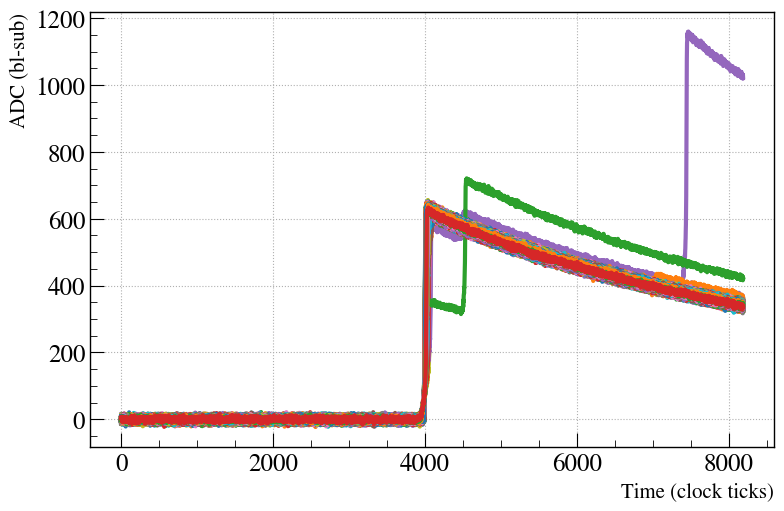

In [61]:
# show some waveforms 

%matplotlib inline
fig = plt.figure()
fig.canvas.header_visible = False

# win_lo, win_hi = 3000, 5000
# win_lo, win_hi = 3500, 4250
# win_lo, win_hi = 3750, 4000 # 10 keV
# win_lo, win_hi = 3820, 4050 # 25 keV

ts = np.arange(len(wfs[0]))
sp = np.mean(wfs, axis=0)

print(wfs.shape)

for iwf in range(wfs.shape[0]):
    
    # plt.plot(ts, wfs[iwf])
    plt.plot(ts, wfs[iwf])
    # plt.plot(ts[win_lo:win_hi], wfs[iwf][win_lo:win_hi], alpha=0.5) 
    
plt.xlabel('Time (clock ticks)', ha='right', x=1, fontsize=15)
plt.ylabel('ADC (bl-sub)', ha='right', y=1, fontsize=15)
plt.show()

## Now that we have the 1400 keV peak waveforms selected, let's PZ-IPZ-PZ correct them

/global/cfs/projectdirs/m2676/users/sjborden/pythonuserbase/lib/python3.11/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: divide by zero encountered in pole_zero
  return self.ufunc(*args, **kwargs)


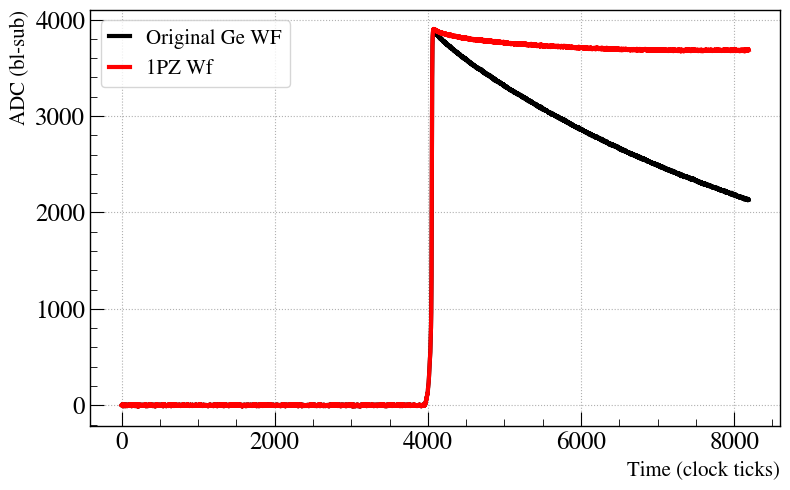

In [6]:
# select a waveform to run tests on
pulse = wfs[0]

# 1pz the waveform

SHIFT_FROM_MAX = 3000 # samples away from the max to start calculating the pz tail correction
BL_IDX = 2000 # Number of samples to calculate the baseline from
idx_flat = np.argmax(pulse) + SHIFT_FROM_MAX
pulse = np.array(pulse, dtype=np.float64)
pz_out = np.array([0], dtype=np.float64)

flattener.optimize_1pz(pulse, np.mean(pulse[:BL_IDX]), int(idx_flat), int(len(pulse)), 26000, pz_out)

pz_tau1 = pz_out[0]
wf_pz = flattener.pole_zero_fwd(pulse, pz_tau1)

# -- diagnostic plot -- 
%matplotlib inline
fig = plt.figure()
fig.canvas.header_visible = False

plt.plot(pulse, c='k', label = 'Original Ge WF')
plt.plot(wf_pz, c='r', label = '1PZ Wf')

plt.xlabel('Time (clock ticks)', ha='right', x=1, fontsize=15)
plt.ylabel('ADC (bl-sub)', ha='right', y=1, fontsize=15)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

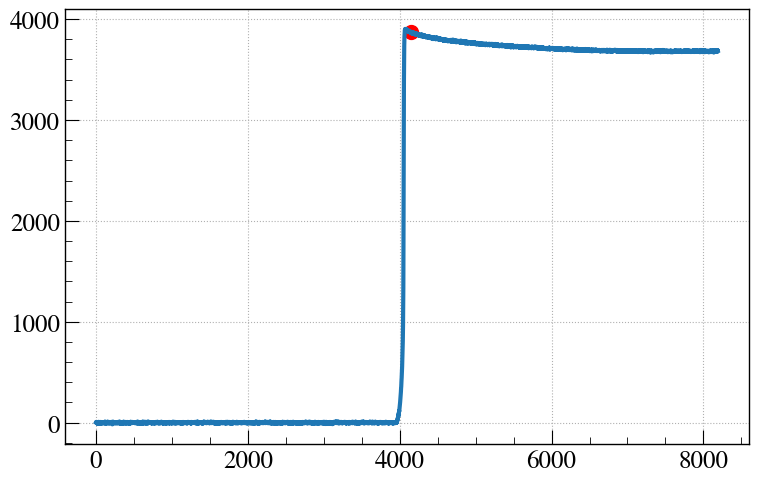

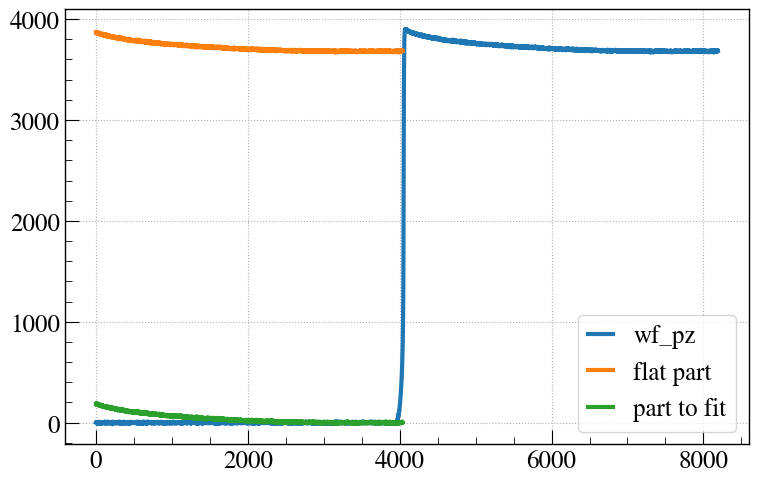

In [7]:
# Now fit an exponential to this and use its time constant to inverse pole zero

# Empirical model of the underdamped SHO responding to a step input 
def model(ts, A, tau, C):
    return A*np.exp(-1*ts/tau) + C # A*exp(tau_short) + B*exp(tau_long) + C.   

# init vals of B & C are both 0, init tau_long = 10x( num samples)

TP0SHIFT = -100 #-11 is great
tp0_guess = np.argmax(np.gradient(wf_pz))-TP0SHIFT
plt.scatter(np.arange(len(wf_pz))[tp0_guess], wf_pz[tp0_guess], c='r')
plt.plot(wf_pz, label='wf_pz')

wf_to_fit = wf_pz[tp0_guess:] - np.mean(wf_pz[-1000:])

%matplotlib inline
fig = plt.figure()
fig.canvas.header_visible = False

plt.plot(wf_pz, label='wf_pz')
plt.plot(wf_pz[tp0_guess:], label='flat part')
plt.plot(wf_to_fit, label='part to fit')
plt.legend()
plt.show()

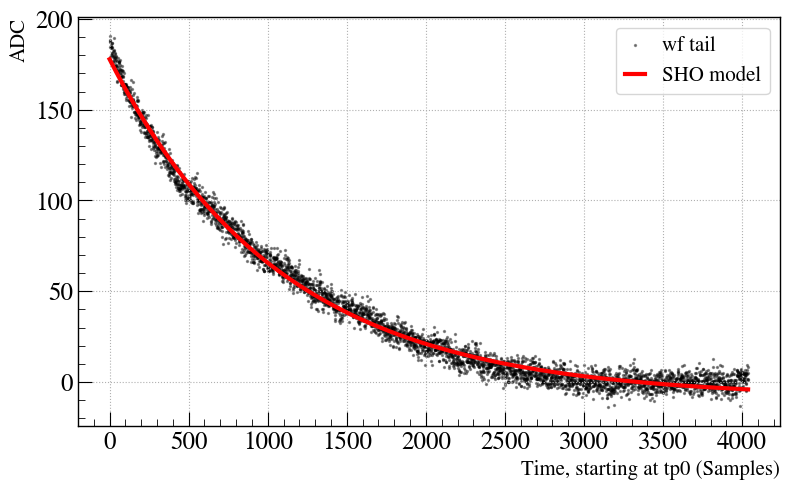

In [8]:
ts = np.arange(0, len(wf_to_fit))

def cost_function(A, tau, C):
    value = 0 
    wf_out = model(ts, A, tau, C)
    for i in range(0, len(ts)):
        value += np.power(wf_to_fit[i]-wf_out[i], 2) # LSQ
    return value

m = Minuit(cost_function, A=300, tau=1.6e3, C=0)
m.limits[0] = (0, None)
m.limits[1] = (0, 1e6)
m.migrad()

pz_tau2 = m.values[1]

# show fit result
ts = np.arange(len(wf_to_fit))

%matplotlib inline
fig = plt.figure()
fig.canvas.header_visible = False

plt.scatter(ts, wf_to_fit, s=2, c='k', alpha=0.4, label='wf tail')
plt.plot(ts, model(ts, *m.values), c='r', label='SHO model')

plt.xlabel("Time, starting at tp0 (Samples)", ha='right', x=1, fontsize=15)
plt.ylabel("ADC", ha='right', y=1, fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()


# SHO model --
# return A*np.exp(-1*ts/tau) # A*exp(tau_short) + B*exp(tau_long) + C.   

# init vals of B & C are both 0, init tau_long = 10x( num samples)

# for an exponential PDF, the average value will be == tau.
# So treat the tail as a PDF.
# Compute the sum of the ADC vals == N .
# get the cdf, and the final val is the norm const.
# Then sum sample number * ADC == S
# Then Tau_short_guess = S/N
# Guess for A is the first ADC value.  This fit should converge pretty rapidly.

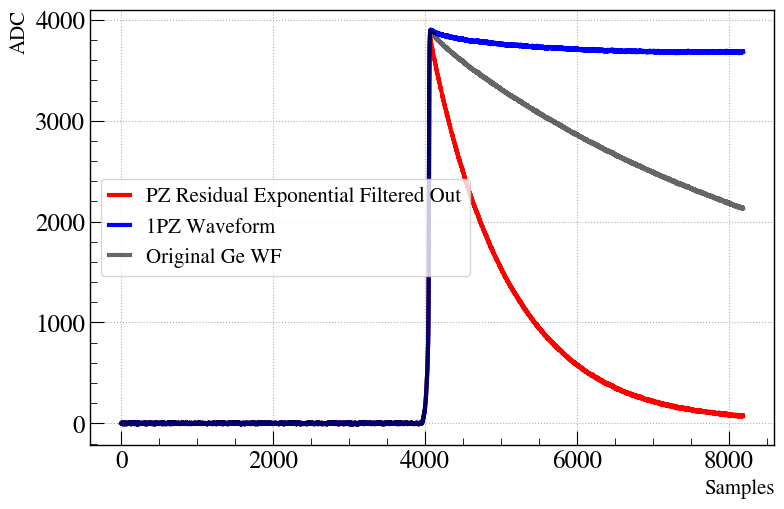

In [9]:
# Filter out the 1PZ waveform's time constant
inverse_pz_pulse = flattener.deconvolve_pz(wf_pz, pz_tau2)

%matplotlib inline
fig = plt.figure()
fig.canvas.header_visible = False

plt.plot(inverse_pz_pulse, label='PZ Residual Exponential Filtered Out', c='r')
plt.plot(wf_pz, label='1PZ Waveform',  c='b')
plt.plot(pulse, label='Original Ge WF', c='k', alpha=0.6)

plt.legend(fontsize=15)
plt.xlabel("Samples", ha='right', x=1, fontsize=15)
plt.ylabel("ADC", ha='right', y=1, fontsize=15)
plt.show()

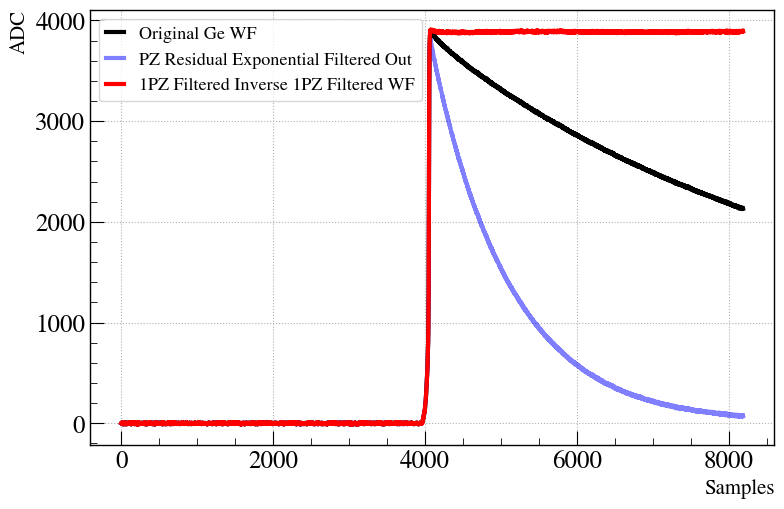

7670.627516522062 1087.0668400885775 1027.8879057803483


In [10]:
# Now fit a PZ constant to the inverse PZ filtered WF.
# (Flattening a WF by Filtering Out the 1PZ WF's Time Constant)

SHIFT_FROM_MAX = 1 
idx_flat = np.argmax(inverse_pz_pulse)+SHIFT_FROM_MAX

inverse_pz_pulse = np.array(inverse_pz_pulse, dtype=np.float64)
flat_out = np.array([0], dtype=np.float64)

flattener.optimize_1pz(inverse_pz_pulse, np.mean(inverse_pz_pulse[:2000]), 
                       int(idx_flat), int(len(inverse_pz_pulse)), 26000, flat_out)

pz_tau3 = flat_out[0]

%matplotlib inline
fig = plt.figure()
fig.canvas.header_visible = False

wf_flat = flattener.pole_zero_fwd(inverse_pz_pulse, pz_tau3)

plt.plot(pulse, c='k', label = 'Original Ge WF')
plt.plot(inverse_pz_pulse, label = 'PZ Residual Exponential Filtered Out', c= 'b', alpha=0.5)
plt.plot(wf_flat, label = '1PZ Filtered Inverse 1PZ Filtered WF', c='r')

plt.legend(fontsize=13, loc=2)
plt.xlabel("Samples", ha='right', x=1, fontsize=15)
plt.ylabel("ADC", ha='right', y=1, fontsize=15)
plt.show()

print(pz_tau1, pz_tau2, pz_tau3)

# Use these parameters on some other waveforms from the 1400 keV peak and see if they all get flat

In [62]:
from pygama.dsp import build_processing_chain as bpc
import pygama.lgdo as lgdo 


# Make a table from the ok values so that dsp can operate properly 
NUM_WFS = len(wfs)
t0s = np.zeros(NUM_WFS)
dts = np.full(len(t0s), 16)
ok_wfs = lgdo.WaveformTable(t0 = t0s, t0_units="ns",\
                            dt = dts, dt_units = "ns",\
                            values = wfs, values_units="ADC")

ok_bls = lgdo.Array(nda = np.array(bl_means))
wf_table = lgdo.Table(size=ok_wfs.size)
wf_table.add_field("waveform", ok_wfs)
wf_table.add_field("baseline", ok_bls)

In [63]:
DEFAULT_DSP_CONFIG = {
        "outputs": [ "wf_pz", "wf_pz_ipz", "wf_pz_ipz_pz"
        ],
        "processors": {

        "wf_pz": {
            "function": "pole_zero",
            "module": "pygama.dsp.processors",
            "args": ["waveform", "db.wf.wf_pz_tau", "wf_pz"],
            "unit": "ADC",
            "defaults": {"db.wf.wf_pz_tau": 7670.627516522062},
            },
            
        "wf_pz_ipz": {
            "function": "inverse_pole_zero",
            "module": "pygama.dsp.processors",
            "args": ["wf_pz", "db.wf.wf_ipz_tau", "wf_pz_ipz"],
            "unit": "ADC",
            "defaults": {"db.wf.wf_ipz_tau": 1087.0668400885775},
            },
            
        "wf_pz_ipz_pz": {
            "function": "pole_zero",
            "module": "pygama.dsp.processors",
            "args": ["wf_pz_ipz", "db.wf.wf_pz_tau_2", "wf_pz_ipz_pz"],
            "unit": "ADC",
            "defaults": {"db.wf.wf_pz_tau_2": 1027.8879057803483},
            },
            
        }
}

In [64]:
proc_chain, _, dsp_out = bpc(wf_table, DEFAULT_DSP_CONFIG)
proc_chain.execute()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


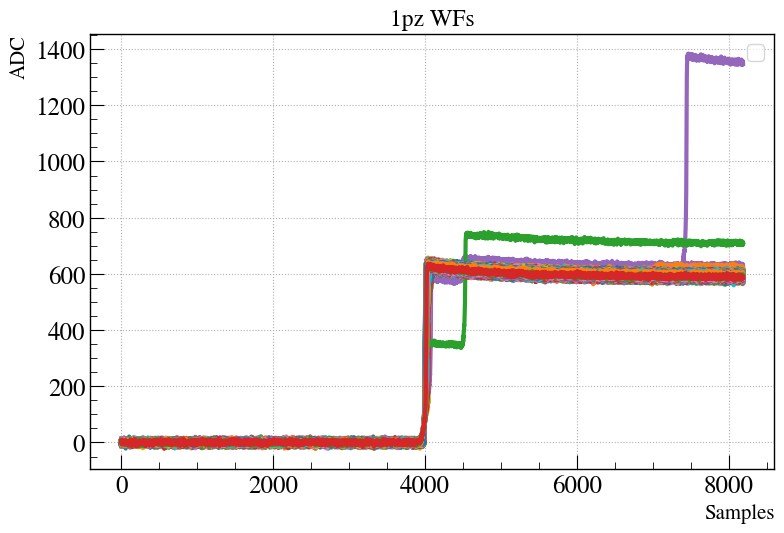

In [65]:
fig = plt.figure()
fig.canvas.header_visible = False

for i in range(NUM_WFS):
    plt.plot(dsp_out['wf_pz'].values.nda[i])
plt.legend(fontsize=15)
plt.xlabel("Samples", ha='right', x=1, fontsize=15)
plt.ylabel("ADC", ha='right', y=1, fontsize=15)
plt.title("1pz WFs")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


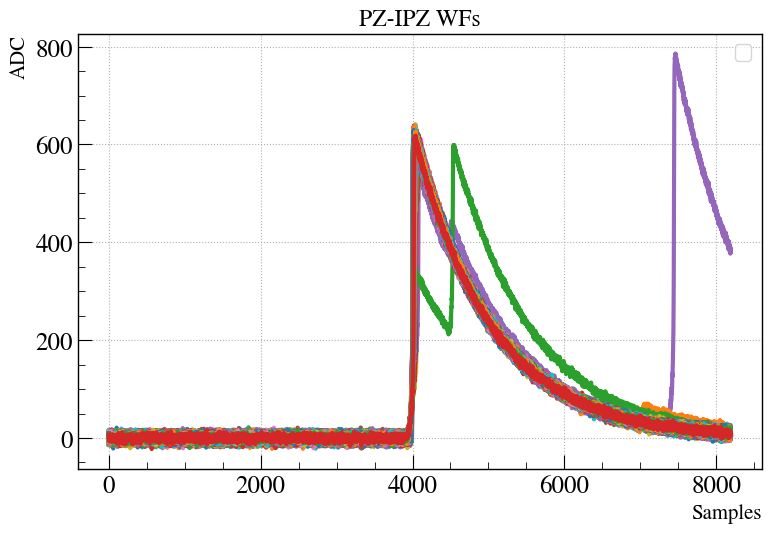

In [66]:
fig = plt.figure()
fig.canvas.header_visible = False

for i in range(NUM_WFS):
    plt.plot(dsp_out['wf_pz_ipz'].values.nda[i])
plt.legend(fontsize=15)
plt.xlabel("Samples", ha='right', x=1, fontsize=15)
plt.ylabel("ADC", ha='right', y=1, fontsize=15)
plt.title("PZ-IPZ WFs")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


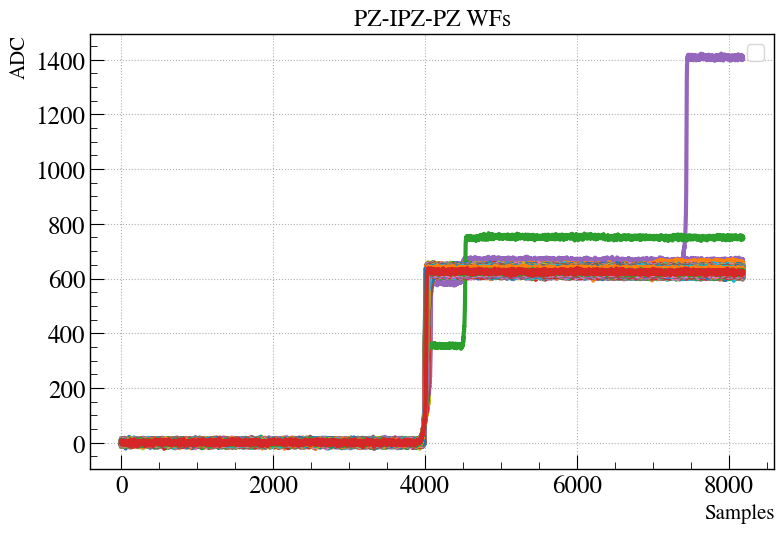

In [67]:
fig = plt.figure()
fig.canvas.header_visible = False

for i in range(NUM_WFS):
    plt.plot(dsp_out['wf_pz_ipz_pz'].values.nda[i])
plt.legend(fontsize=15)
plt.xlabel("Samples", ha='right', x=1, fontsize=15)
plt.ylabel("ADC", ha='right', y=1, fontsize=15)
plt.title("PZ-IPZ-PZ WFs")
plt.show()